<a href="https://colab.research.google.com/github/pineapple-666/Detect-Sepsis-in-Patients-Before-it-Emerges/blob/main/notebook/Step1_Data_Exploring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [150]:
!pip install ISLP
from ISLP.models import ( ModelSpec as MS ,
summarize ,
poly)

### Importing and splitting the data into training and testing



In [151]:
url = "https://raw.github.com/pineapple-666/Detect-Sepsis-in-Patients-Before-it-Emerges/main/data/train.csv.zip"
raw_data = pd.read_csv(url)
print(raw_data.head(3))

   patient  time    HR  O2Sat   Temp    SBP   MAP   DBP  Resp  EtCO2  ...  \
0    16426     1   NaN    NaN    NaN    NaN   NaN   NaN   NaN    NaN  ...   
1    16426     2  78.0   99.5  35.25  108.5  84.5  69.0  12.0    NaN  ...   
2    16426     3  80.0   99.0  36.20  113.0  87.0  73.0  12.0    NaN  ...   

    WBC  Fibrinogen  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  \
0   NaN         NaN        NaN  57.03     1.0    0.0    1.0        -4.25   
1  14.2         NaN        NaN  57.03     1.0    0.0    1.0        -4.25   
2   NaN         NaN        NaN  57.03     1.0    0.0    1.0        -4.25   

   ICULOS  SepsisLabel  
0     1.0          0.0  
1     2.0          0.0  
2     3.0          0.0  

[3 rows x 43 columns]


In [152]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1088197 entries, 0 to 1088196
Data columns (total 43 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   patient           1088197 non-null  int64  
 1   time              1088197 non-null  int64  
 2   HR                980967 non-null   float64
 3   O2Sat             947133 non-null   float64
 4   Temp              369212 non-null   float64
 5   SBP               931096 non-null   float64
 6   MAP               953029 non-null   float64
 7   DBP               749357 non-null   float64
 8   Resp              921122 non-null   float64
 9   EtCO2             41511 non-null    float64
 10  BaseExcess        58822 non-null    float64
 11  HCO3              45312 non-null    float64
 12  FiO2              90753 non-null    float64
 13  pH                75490 non-null    float64
 14  PaCO2             60609 non-null    float64
 15  SaO2              37520 non-null    float64
 16  

In [153]:
raw_data['patient'].unique().size

28235

In [154]:
import random
random.seed(1)
num_patients_20_percent = 28235 * 0.2
random_numbers = random.sample(range(28236), int(num_patients_20_percent))

In [155]:
train_df = raw_data[~raw_data['patient'].isin(random_numbers)].copy()
valid_df = raw_data[raw_data['patient'].isin(random_numbers)].copy()

print(train_df.shape)
print(valid_df.shape)

(871065, 43)
(217132, 43)


In [156]:
total_rows_split = len(train_df) + len(valid_df)
total_rows_raw = len(raw_data)
print(total_rows_split)
print(total_rows_raw)

1088197
1088197


In [157]:
print(train_df.shape[0] / raw_data.shape[0])

0.8004662758673292


### Exploratory data analysis

In [158]:
train_df.head(15)

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
43,16371,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,67.0,1.0,NaN,NaN,-42.19,1.0,0.0
44,16371,2,90.0,93.0,36.9,120.0,85.0,70.0,18.0,NaN,...,NaN,NaN,NaN,67.0,1.0,NaN,NaN,-42.19,2.0,0.0
45,16371,3,95.0,94.0,NaN,108.5,78.5,68.0,17.5,NaN,...,NaN,NaN,NaN,67.0,1.0,NaN,NaN,-42.19,3.0,0.0
46,16371,4,96.0,96.0,NaN,117.0,83.0,73.5,16.5,NaN,...,NaN,NaN,NaN,67.0,1.0,NaN,NaN,-42.19,4.0,0.0
47,16371,5,97.0,95.0,NaN,118.0,81.0,71.0,15.0,NaN,...,NaN,NaN,NaN,67.0,1.0,NaN,NaN,-42.19,5.0,0.0
48,16371,6,99.0,99.0,NaN,117.0,91.0,84.0,18.0,NaN,...,NaN,NaN,NaN,67.0,1.0,NaN,NaN,-42.19,6.0,0.0
49,16371,7,92.0,97.0,36.7,114.0,85.0,74.0,16.0,NaN,...,NaN,NaN,NaN,67.0,1.0,NaN,NaN,-42.19,7.0,0.0
50,16371,8,92.0,92.0,NaN,122.0,83.0,74.0,18.0,NaN,...,NaN,NaN,NaN,67.0,1.0,NaN,NaN,-42.19,8.0,0.0
51,16371,9,93.0,97.0,NaN,112.0,82.0,72.0,17.0,NaN,...,NaN,NaN,NaN,67.0,1.0,NaN,NaN,-42.19,9.0,0.0
52,16371,10,89.0,95.0,NaN,106.0,79.0,72.0,16.0,NaN,...,NaN,NaN,NaN,67.0,1.0,NaN,NaN,-42.19,10.0,0.0


In [159]:
train_df.columns

Index(['patient', 'time', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp',
       'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST',
       'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine',
       'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate',
       'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [160]:
# Percentage of null values present in all the parameters

null_values = train_df.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

,0
Bilirubin_direct,99.801393
Fibrinogen,99.311188
TroponinI,99.040255
Bilirubin_total,98.498734
Alkalinephos,98.385769
AST,98.369812
Lactate,97.340038
PTT,97.048670
SaO2,96.572127
EtCO2,96.160218


In [161]:
# the features have been removed based on the number of null values and redundancy

# 'SBP' -- MAP is considered instead of SBP and DBP
# 'DBP' -- MAP is considered instead of SBP and DBP
# 'EtCO2' -- It is not readily. available and also not available in the dataset
# 'BaseExcess' -- It is an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'HCO3' -- It is also an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'pH' -- It is also an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'PaCO2' -- It is an indicator of respiratory health of an individual, we are considering SaO2 and FiO2 which are more readily avaiilable
# 'Alkalinephos' -- It is an indicator of the health of the liver of an individual, but we are considering Bilirubin instead of this, as data of this is more scarce.
# 'Calcium' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'Magnesium' -- It is an indicator of metabolism and kidney health, but we are considering Lactate instead as it is more readily available
# 'Phosphate' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'Potassium' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'PTT' -- It is used to check inflammation. We are using WBC counts instead as it is easy to obtain.
# 'Fibrinogen' -- It is used to check blood clotting ability. We are using Platelets instead, as it is easier to obtain.
# 'Unit1' -- Both the columns Unit1 and Unit2 have been merged to form a single column.
# 'Unit2' -- Both the columns Unit1 and Unit2 have been merged to form a single column.
# 'Bilirubin_direct' -- Total bilirubin is considered instead of Bilirubin_direct
# 'Hgb' -- Hct(Hemoglobin (g/dL)) is considered instead of Hgb(Hemoglobin (g/dL)) Hematocrit≈3×Hemoglobin

columns_drop={'SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium',
'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2', 'Bilirubin_direct', 'Hgb'}
train_df = train_df.assign(Unit=train_df['Unit1'] + train_df['Unit2'])
train_df_mod = train_df.drop(columns=columns_drop)
train_df_mod.columns

Index(['patient', 'time', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'FiO2', 'SaO2',
       'AST', 'BUN', 'Chloride', 'Creatinine', 'Glucose', 'Lactate',
       'Bilirubin_total', 'TroponinI', 'Hct', 'WBC', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Unit'],
      dtype='object')

In [162]:
# the features have been removed based on the number of null values and redundancy

# 'SBP' -- MAP is considered instead of SBP and DBP
# 'DBP' -- MAP is considered instead of SBP and DBP
# 'EtCO2' -- It is not readily. available and also not available in the dataset
# 'BaseExcess' -- It is an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'HCO3' -- It is also an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'pH' -- It is also an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'PaCO2' -- It is an indicator of respiratory health of an individual, we are considering SaO2 and FiO2 which are more readily avaiilable
# 'Alkalinephos' -- It is an indicator of the health of the liver of an individual, but we are considering Bilirubin instead of this, as data of this is more scarce.
# 'Calcium' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'Magnesium' -- It is an indicator of metabolism and kidney health, but we are considering Lactate instead as it is more readily available
# 'Phosphate' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'Potassium' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'PTT' -- It is used to check inflammation. We are using WBC counts instead as it is easy to obtain.
# 'Fibrinogen' -- It is used to check blood clotting ability. We are using Platelets instead, as it is easier to obtain.
# 'Unit1' -- Both the columns Unit1 and Unit2 have been merged to form a single column.
# 'Unit2' -- Both the columns Unit1 and Unit2 have been merged to form a single column.
# 'Bilirubin_direct' -- Total bilirubin is considered instead of Bilirubin_direct
# 'Hgb' -- Hct(Hemoglobin (g/dL)) is considered instead of Hgb(Hemoglobin (g/dL)) Hematocrit≈3×Hemoglobin

columns_drop={'SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium',
'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2', 'Bilirubin_direct', 'Hgb'}
train_df = train_df.assign(Unit=train_df['Unit1'] + train_df['Unit2'])
train_df_mod = train_df.drop(columns=columns_drop)
train_df_mod.columns

Index(['patient', 'time', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'FiO2', 'SaO2',
       'AST', 'BUN', 'Chloride', 'Creatinine', 'Glucose', 'Lactate',
       'Bilirubin_total', 'TroponinI', 'Hct', 'WBC', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Unit'],
      dtype='object')

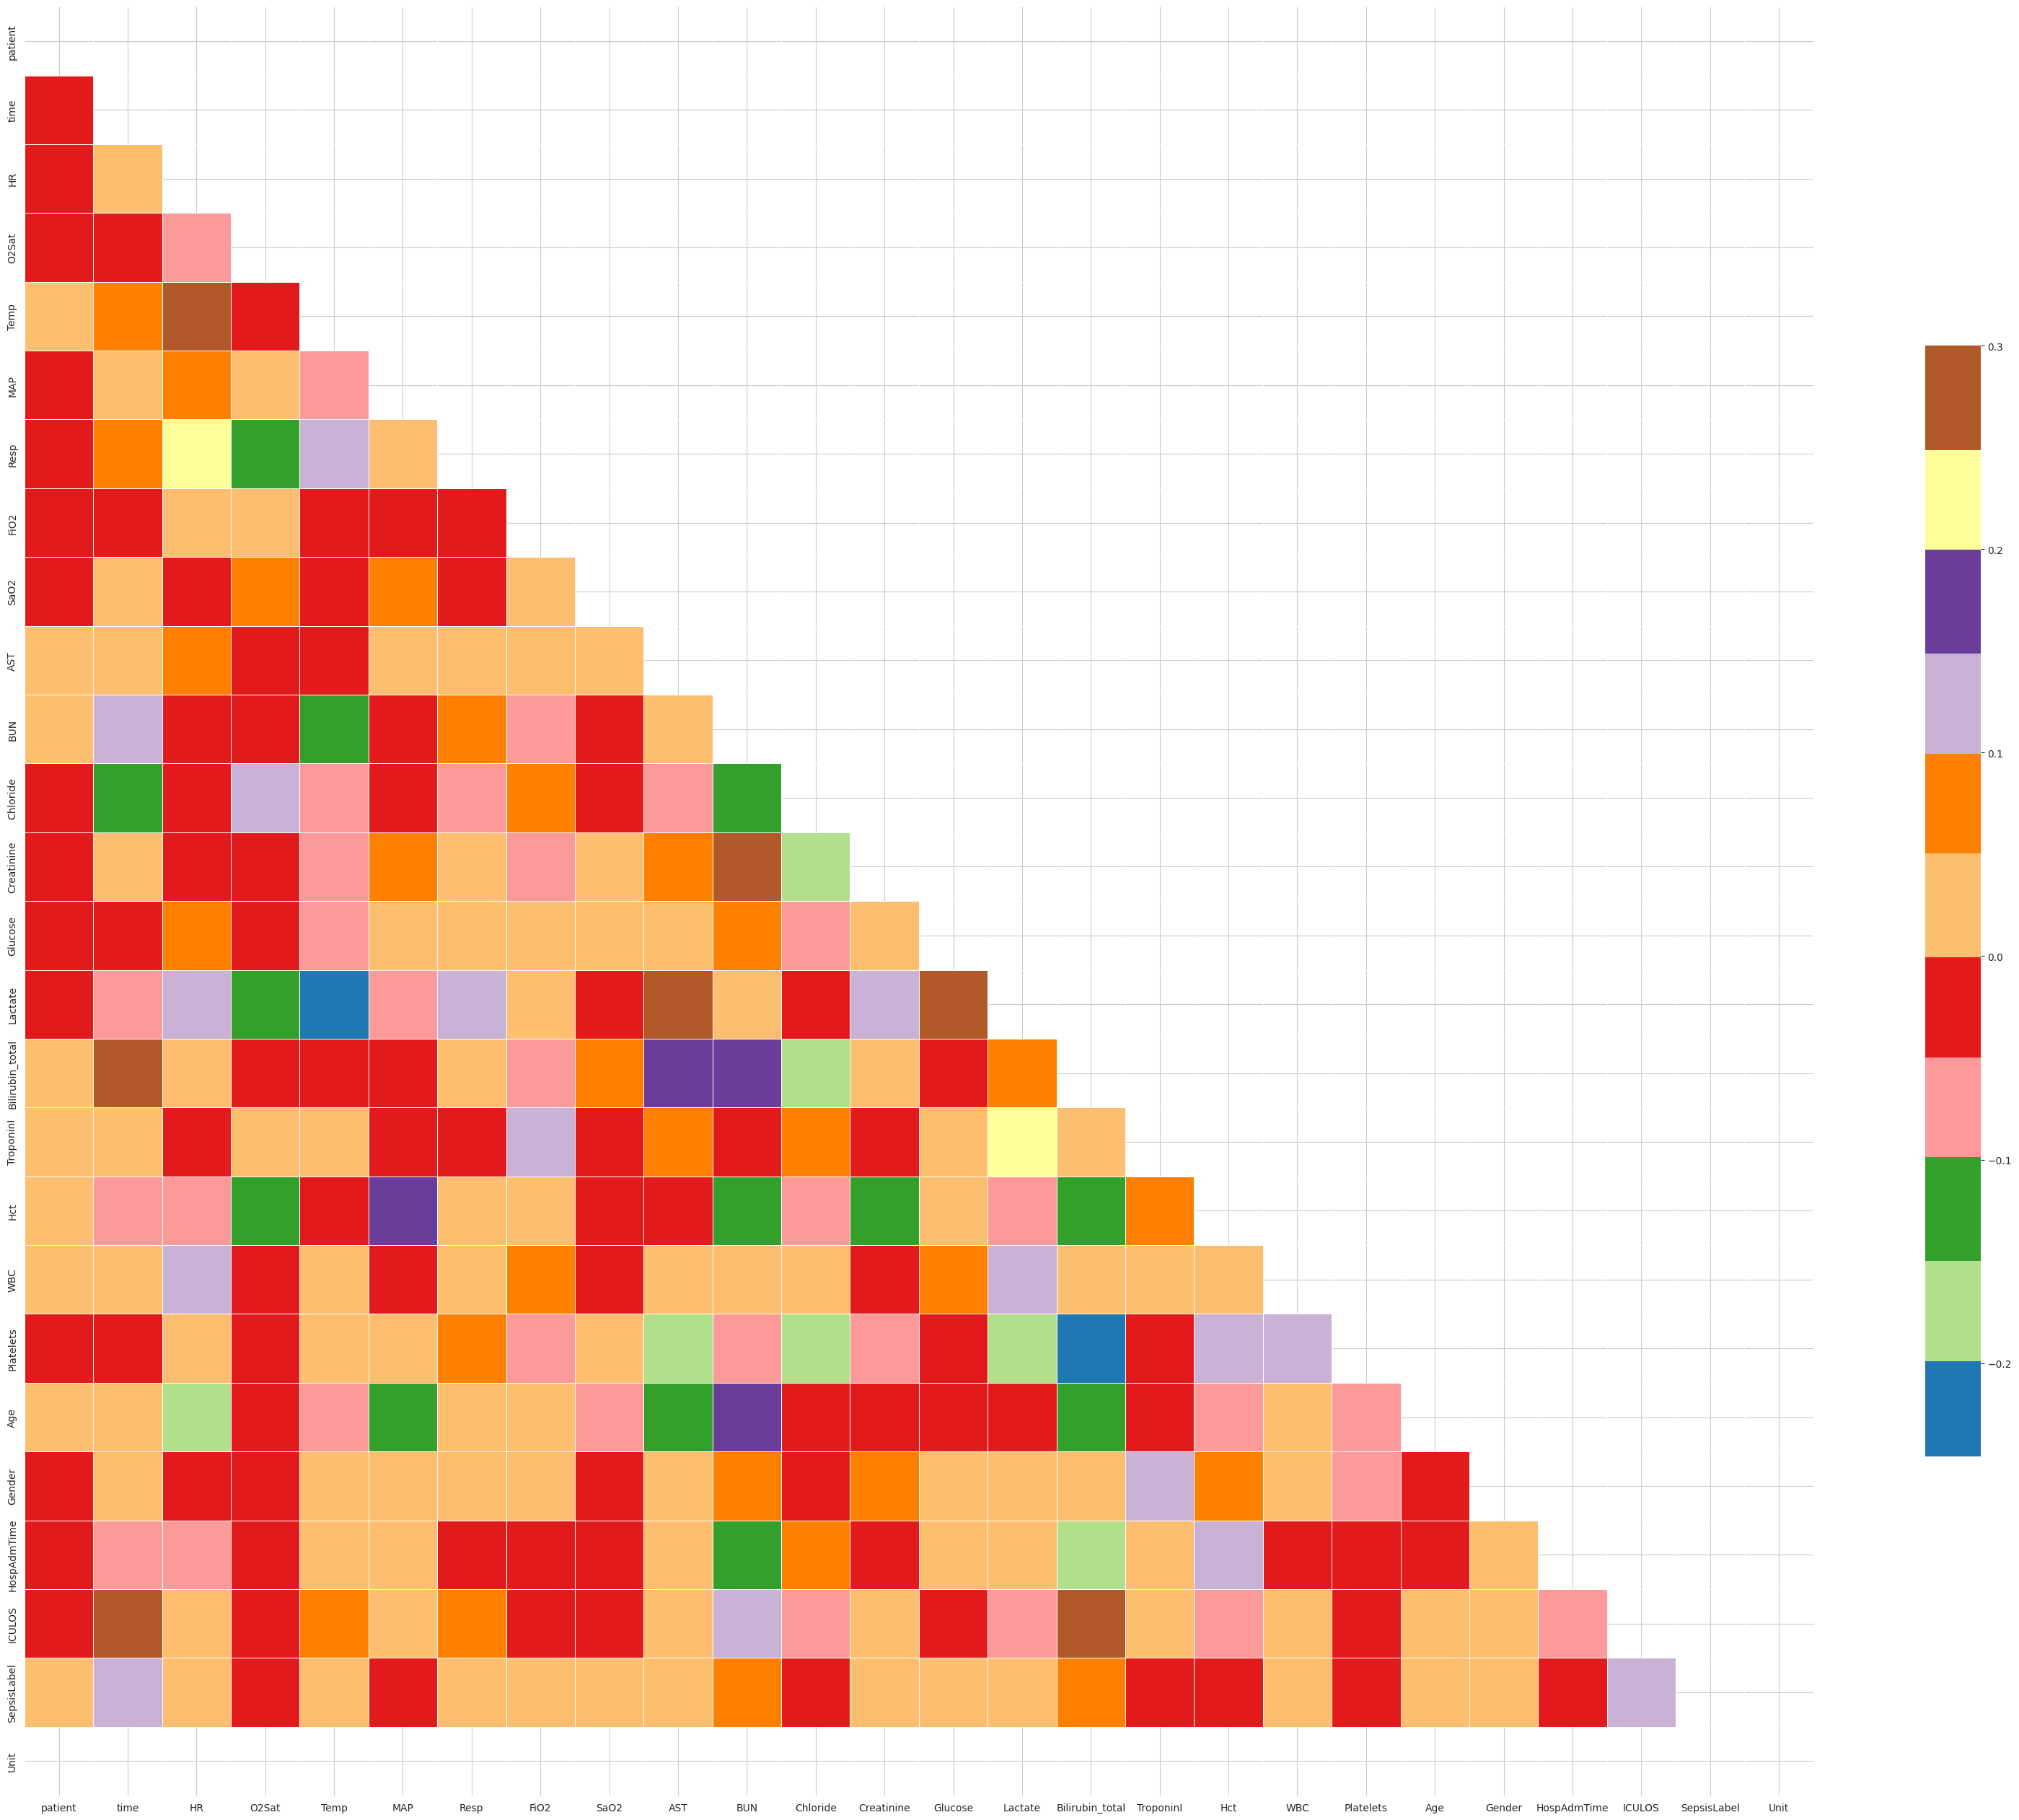

In [163]:
# Function to draw correlation heat map

def corr_matrix(df):
  corr = df.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))
  f, ax = plt.subplots(figsize=(40,40))
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(corr, mask=mask, cmap="Paired", vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

corr_matrix(train_df_mod)

In [164]:
corr_values_train_df = train_df_mod.corr()
display(corr_values_train_df)

,patient,time,HR,O2Sat,Temp,MAP,Resp,FiO2,SaO2,AST,...,TroponinI,Hct,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,Unit
patient,1.000000,-0.005254,-0.003602,-0.010024,0.004615,-0.012101,-0.009570,-0.005461,-0.004997,0.010195,...,0.026367,0.008130,0.012305,-0.000793,0.016139,-0.007527,-0.008948,-0.005462,-0.000139,NaN
time,-0.005254,1.000000,0.040508,-0.047266,0.071031,0.033583,0.095260,-0.004019,0.002841,0.020928,...,0.043437,-0.089940,0.000513,-0.033422,0.011046,0.013633,-0.079323,0.992765,0.133713,NaN
HR,-0.003602,0.040508,1.000000,-0.080754,0.257040,0.068580,0.227014,0.004608,-0.009989,0.054281,...,-0.008771,-0.074353,0.123215,0.030679,-0.160096,-0.032525,-0.056352,0.041691,0.049818,NaN
O2Sat,-0.010024,-0.047266,-0.080754,1.000000,-0.032091,0.023700,-0.147479,0.000550,0.094658,-0.007460,...,0.011579,-0.117084,-0.033697,-0.022468,-0.047008,-0.025220,-0.004883,-0.045837,-0.009750,NaN
Temp,0.004615,0.071031,0.257040,-0.032091,1.000000,-0.065031,0.111727,-0.005663,-0.019831,-0.012280,...,0.004746,-0.046677,0.034349,0.002660,-0.068277,0.047882,0.002894,0.076646,0.043113,NaN
MAP,-0.012101,0.033583,0.068580,0.023700,-0.065031,1.000000,0.048065,-0.004744,0.098524,0.022454,...,-0.049285,0.176179,-0.042511,0.043591,-0.144230,0.003251,0.042398,0.029121,-0.021138,NaN
Resp,-0.009570,0.095260,0.227014,-0.147479,0.111727,0.048065,1.000000,-0.000835,-0.032784,0.012339,...,-0.001437,0.026941,0.042886,0.063812,0.034037,0.004069,-0.030984,0.094600,0.045259,NaN
FiO2,-0.005461,-0.004019,0.004608,0.000550,-0.005663,-0.004744,-0.000835,1.000000,0.001916,0.046845,...,0.108826,0.021197,0.087216,-0.064029,0.000750,0.003657,-0.000923,-0.004085,-0.000376,NaN
SaO2,-0.004997,0.002841,-0.009989,0.094658,-0.019831,0.098524,-0.032784,0.001916,1.000000,0.011041,...,-0.023604,-0.046994,-0.045031,0.002737,-0.096670,-0.001489,-0.006188,-0.001529,0.011707,NaN
AST,0.010195,0.020928,0.054281,-0.007460,-0.012280,0.022454,0.012339,0.046845,0.011041,1.000000,...,0.094095,-0.034775,0.028838,-0.152484,-0.108647,0.010157,0.030991,0.022000,0.013944,NaN


In [165]:
corr_threshold = 0.6
high_corr_pairs = []

# Iterate through the correlation matrix for train_df_mod
for i in range(len(corr_values_train_df.columns)):
    for j in range(i + 1, len(corr_values_train_df.columns)): # Start from i+1 to avoid self-correlation and duplicates
        if abs(corr_values_train_df.iloc[i, j]) > corr_threshold:
            high_corr_pairs.append({
                'Feature 1': corr_values_train_df.columns[i],
                'Feature 2': corr_values_train_df.columns[j],
                'Correlation': corr_values_train_df.iloc[i, j]
            })

# Convert to DataFrame for better display
high_corr_df = pd.DataFrame(high_corr_pairs)
display(high_corr_df.sort_values(by='Correlation', ascending=False))

,Feature 1,Feature 2,Correlation
0,time,ICULOS,0.992765
1,BUN,Creatinine,0.636178


### Imputation

In [166]:
train_df_impute = train_df_mod.copy()
columns_impute = list(train_df_impute.columns)

In [167]:
# bfill and ffill for imputing
# bfill first because usually a record approaching the end is usually worse, as the development of an illness

grouped_by_patient = train_df_impute.groupby('patient')
train_df_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())

/tmp/ipython-input-1180001563.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())


In [168]:
train_df_impute.head()

patient  time    HR  O2Sat   Temp   MAP  Resp  FiO2  SaO2  \
patient                                                                     
1       994377        1     1  75.0   95.0  36.11  60.0  18.0   NaN   NaN   
        994378        1     2  75.0   95.0  36.11  60.0  18.0   NaN   NaN   
        994379        1     3  79.0   94.0  36.11  63.0  22.0   NaN   NaN   
        994380        1     4  81.0   96.0  37.94  64.0  23.0   NaN   NaN   
        994381        1     5  80.0   96.0  37.94  64.0  23.0   NaN   NaN   

                 AST  ...  TroponinI   Hct  WBC  Platelets    Age  Gender  \
patient               ...                                                   
1       994377  74.0  ...        NaN  31.4  8.4      169.0  84.52     0.0   
        994378  74.0  ...        NaN  31.4  8.4      169.0  84.52     0.0   
        994379  74.0  ...        NaN  31.4  8.4      169.0  84.52     0.0   
        994380  74.0  ...        NaN  31.4  8.4      169.0  84.52     0.0   
        994381  74.0  ...        NaN  31.4  8.4      169.0  84.52     0.0   

                HospAdmTime  ICULOS  SepsisLabel  Unit  
patient                                                 
1       994377       -80.25     1.0          0.0   NaN  
        994378       -80.25     2.0          0.0   NaN  
        994379       -80.25     3.0          0.0   NaN  
        994380       -80.25     4.0          0.0   NaN  
        994381       -80.25     5.0          0.0   NaN  

[5 rows x 26 columns]

In [169]:
# Now let's check the remaining proportion of missing values

null_values = train_df_impute.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

,0
TroponinI,81.932232
Lactate,63.530506
SaO2,62.897717
Bilirubin_total,59.849150
AST,59.595438
FiO2,50.277534
Chloride,45.100767
Unit,39.090194
WBC,4.101416
Platelets,4.021629


In [170]:
# dropping all the columns with null values more than 25%

null_col = ['TroponinI', 'Lactate','AST','SaO2', 'Bilirubin_total', 'FiO2','Chloride','Unit']
train_df_impute = train_df_impute.drop(columns=null_col)
train_df_impute.columns

Index(['patient', 'time', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN',
       'Creatinine', 'Glucose', 'Hct', 'WBC', 'Platelets', 'Age', 'Gender',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')


### Keep One Record for Each Patient:
####SepsisLabel == 1
Patients:For patients who show SepsisLabel = 1 at any point, I will identify their very first record where SepsisLabel becomes 1 (ordered by time) and keep only that record.
####Never SepsisLabel == 1
Patients: For patients who never have SepsisLabel = 1, I will average all their records to create a single representative record for each of them.


In [171]:
sepsis_patients_ids = train_df_impute[train_df_impute['SepsisLabel'] == 1]['patient'].unique()
print(len(sepsis_patients_ids))

1642


In [172]:
train_df_impute_reset = train_df_impute.reset_index(level=0, drop=True)

# 1. Filter train_df_impute for patients identified as sepsis-positive
sepsis_positive_records = train_df_impute_reset[train_df_impute_reset['patient'].isin(sepsis_patients_ids)].copy()

# 2. Further filter to keep only records where SepsisLabel is equal to 1
sepsis_positive_records_only = sepsis_positive_records[sepsis_positive_records['SepsisLabel'] == 1].copy()

# 3. Group by 'patient' and select the row with the minimum 'time' value
earliest_sepsis_records = sepsis_positive_records_only.loc[sepsis_positive_records_only.groupby('patient')['time'].idxmin()]

# Display the shape and head of the resulting DataFrame
print(f"Shape of earliest_sepsis_records: {earliest_sepsis_records.shape}")
print("Head of earliest_sepsis_records:")
display(earliest_sepsis_records.head())

Shape of earliest_sepsis_records: (1642, 18)
Head of earliest_sepsis_records:


,patient,time,HR,O2Sat,Temp,MAP,Resp,BUN,Creatinine,Glucose,Hct,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel
171604,6,69,89.0,100.0,37.39,86.0,22.0,7.0,0.7,75.0,28.6,10.3,193.0,58.18,1.0,-181.00,69.0,1.0
447630,33,111,111.0,96.0,37.00,97.0,18.0,23.0,0.6,117.0,32.8,8.4,129.0,30.04,0.0,-0.02,113.0,1.0
786042,37,183,63.0,90.0,36.39,64.0,17.0,85.0,1.4,78.0,32.6,13.8,103.0,59.73,1.0,-1197.09,183.0,1.0
972943,54,114,88.0,100.0,36.11,76.0,17.0,51.0,5.7,163.0,31.7,18.9,365.0,65.75,1.0,-96.90,123.0,1.0
950826,62,104,116.0,99.0,37.44,73.0,18.0,32.0,1.4,106.0,23.0,17.9,759.0,37.05,0.0,-304.97,104.0,1.0


In [173]:
all_patients_ids = train_df_impute_reset['patient'].unique()
sepsis_negative_patient_ids = np.setdiff1d(all_patients_ids, sepsis_patients_ids)

print(len(sepsis_negative_patient_ids))

20946


In [174]:
sepsis_negative_records = train_df_impute_reset[train_df_impute_reset['patient'].isin(sepsis_negative_patient_ids)].copy()

# Group by 'patient' and calculate the mean for all other columns
mean_sepsis_negative_records = sepsis_negative_records.groupby('patient').mean(numeric_only=True).reset_index()

print(f"Shape of mean_sepsis_negative_records: {mean_sepsis_negative_records.shape}")
print("Head of mean_sepsis_negative_records:")
display(mean_sepsis_negative_records.head())

Shape of mean_sepsis_negative_records: (20946, 18)
Head of mean_sepsis_negative_records:


,patient,time,HR,O2Sat,Temp,MAP,Resp,BUN,Creatinine,Glucose,Hct,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel
0,1,18.5,77.611111,95.638889,36.888611,68.097222,20.125000,13.000000,0.700000,117.000000,31.400000,8.4000,169.000000,84.52,0.0,-80.25,18.5,0.0
1,2,14.5,81.392857,97.089286,37.775000,77.368929,19.026786,25.857143,1.385714,112.285714,24.328571,19.4000,420.071429,52.38,1.0,-226.80,17.5,0.0
2,3,9.5,102.361111,97.388889,37.547778,88.583333,16.638889,11.000000,0.900000,179.666667,39.300000,28.7000,481.000000,52.63,1.0,-29.19,9.5,0.0
3,4,24.5,118.500000,94.229167,37.207292,75.479167,17.500000,17.375000,1.193125,161.125000,25.368750,21.8375,76.312500,53.00,1.0,-82.42,24.5,0.0
4,5,10.0,64.921053,98.026316,36.410526,76.447368,18.447368,16.000000,0.920000,170.000000,31.900000,11.9000,224.000000,80.00,1.0,-9.59,10.0,0.0


In [175]:
aggregated_df = pd.concat([earliest_sepsis_records, mean_sepsis_negative_records], ignore_index=True).drop(columns=['time'])

print(f"Shape of the aggregated DataFrame: {aggregated_df.shape}")
print("Head of the aggregated DataFrame:")
display(aggregated_df.head())

Shape of the aggregated DataFrame: (22588, 17)
Head of the aggregated DataFrame:


,patient,HR,O2Sat,Temp,MAP,Resp,BUN,Creatinine,Glucose,Hct,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel
0,6,89.0,100.0,37.39,86.0,22.0,7.0,0.7,75.0,28.6,10.3,193.0,58.18,1.0,-181.00,69.0,1.0
1,33,111.0,96.0,37.00,97.0,18.0,23.0,0.6,117.0,32.8,8.4,129.0,30.04,0.0,-0.02,113.0,1.0
2,37,63.0,90.0,36.39,64.0,17.0,85.0,1.4,78.0,32.6,13.8,103.0,59.73,1.0,-1197.09,183.0,1.0
3,54,88.0,100.0,36.11,76.0,17.0,51.0,5.7,163.0,31.7,18.9,365.0,65.75,1.0,-96.90,123.0,1.0
4,62,116.0,99.0,37.44,73.0,18.0,32.0,1.4,106.0,23.0,17.9,759.0,37.05,0.0,-304.97,104.0,1.0


## Statistics Summary

In [176]:
aggregated_df.describe().round(2)

,patient,HR,O2Sat,Temp,MAP,Resp,BUN,Creatinine,Glucose,Hct,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel
count,22588.00,22583.00,22575.00,22424.00,22529.00,22545.00,21514.00,21494.00,21750.00,21349.00,21173.00,21204.00,22588.00,22588.00,22587.00,22588.00,22588.00
mean,14135.38,83.88,97.12,36.84,82.86,18.54,21.93,1.42,130.33,31.86,11.02,204.22,61.61,0.56,-51.52,21.83,0.07
std,8160.72,14.85,2.33,0.56,13.12,3.60,17.87,1.74,38.97,5.44,6.72,100.63,16.56,0.50,134.79,20.11,0.26
min,1.00,21.00,33.81,32.00,23.00,1.00,1.00,0.10,19.00,9.30,0.10,4.00,14.00,0.00,-3269.10,1.00,0.00
25%,7040.75,73.43,96.11,36.50,73.69,16.32,11.12,0.70,105.89,27.95,7.60,138.47,51.00,0.00,-43.34,13.00,0.00
50%,14148.00,83.05,97.38,36.81,81.09,18.10,16.27,0.90,122.85,31.30,10.10,189.00,63.01,1.00,-6.06,20.50,0.00
75%,21228.25,93.23,98.53,37.18,90.43,20.29,25.72,1.30,143.85,35.40,13.20,250.00,74.00,1.00,-0.04,24.50,0.00
max,28235.00,182.00,100.00,40.56,250.00,61.50,182.61,24.39,667.00,66.91,307.39,2322.00,100.00,1.00,20.04,331.00,1.00


In [177]:
aggregated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22588 entries, 0 to 22587
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   patient      22588 non-null  int64  
 1   HR           22583 non-null  float64
 2   O2Sat        22575 non-null  float64
 3   Temp         22424 non-null  float64
 4   MAP          22529 non-null  float64
 5   Resp         22545 non-null  float64
 6   BUN          21514 non-null  float64
 7   Creatinine   21494 non-null  float64
 8   Glucose      21750 non-null  float64
 9   Hct          21349 non-null  float64
 10  WBC          21173 non-null  float64
 11  Platelets    21204 non-null  float64
 12  Age          22588 non-null  float64
 13  Gender       22588 non-null  float64
 14  HospAdmTime  22587 non-null  float64
 15  ICULOS       22588 non-null  float64
 16  SepsisLabel  22588 non-null  float64
dtypes: float64(16), int64(1)
memory usage: 2.9 MB


In [178]:
null_values = aggregated_df.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

,0
WBC,6.264388
Platelets,6.127147
Hct,5.485213
Creatinine,4.843280
BUN,4.754737
Glucose,3.709934
Temp,0.726049
MAP,0.261201
Resp,0.190367
O2Sat,0.057553


/tmp/ipython-input-3334111865.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='SepsisLabel', y=col, data=aggregated_df, palette='viridis')


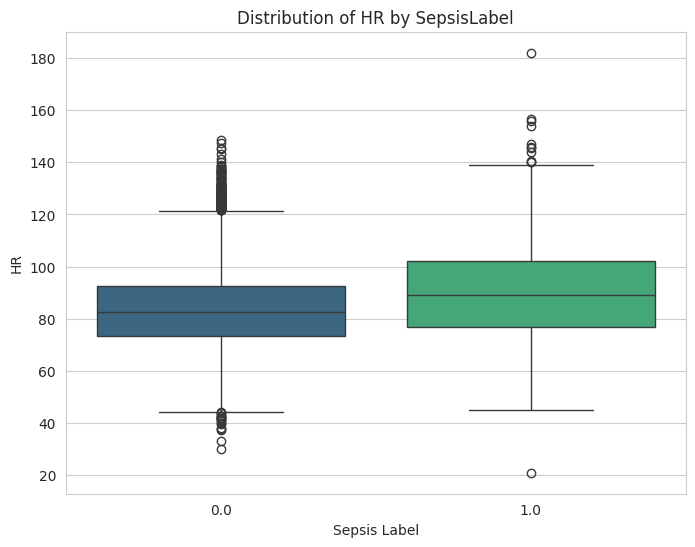

/tmp/ipython-input-3334111865.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='SepsisLabel', y=col, data=aggregated_df, palette='viridis')


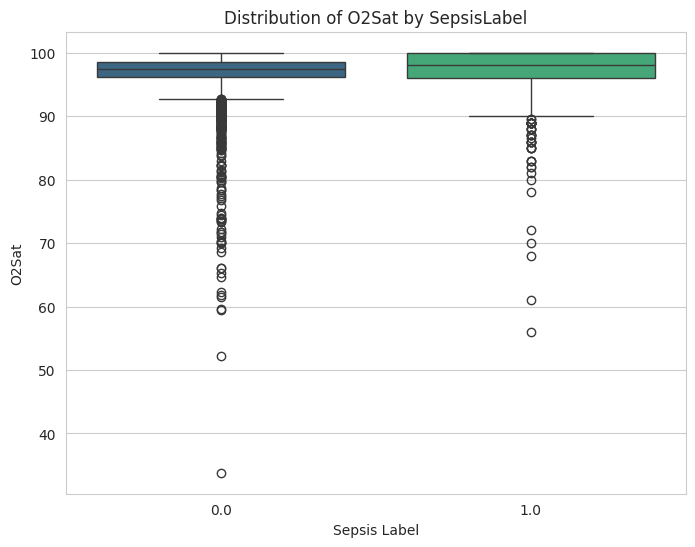

/tmp/ipython-input-3334111865.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='SepsisLabel', y=col, data=aggregated_df, palette='viridis')


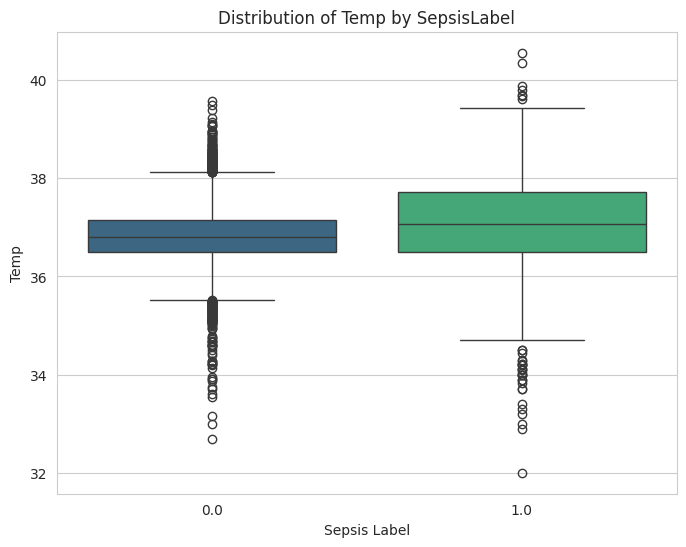

/tmp/ipython-input-3334111865.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='SepsisLabel', y=col, data=aggregated_df, palette='viridis')


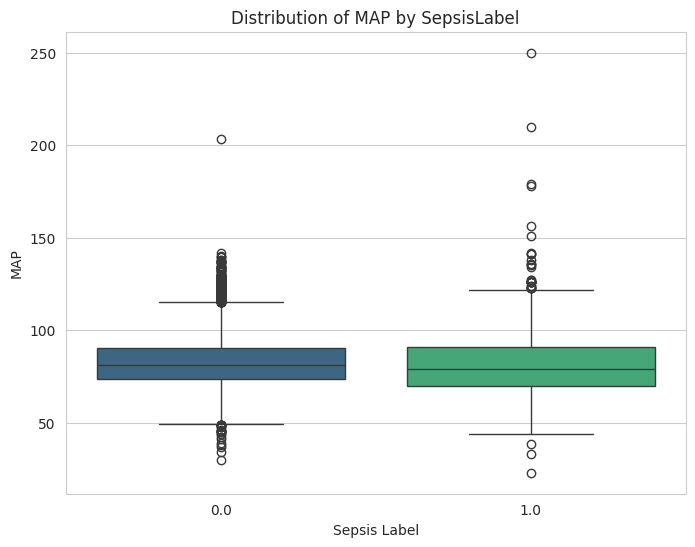

/tmp/ipython-input-3334111865.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='SepsisLabel', y=col, data=aggregated_df, palette='viridis')


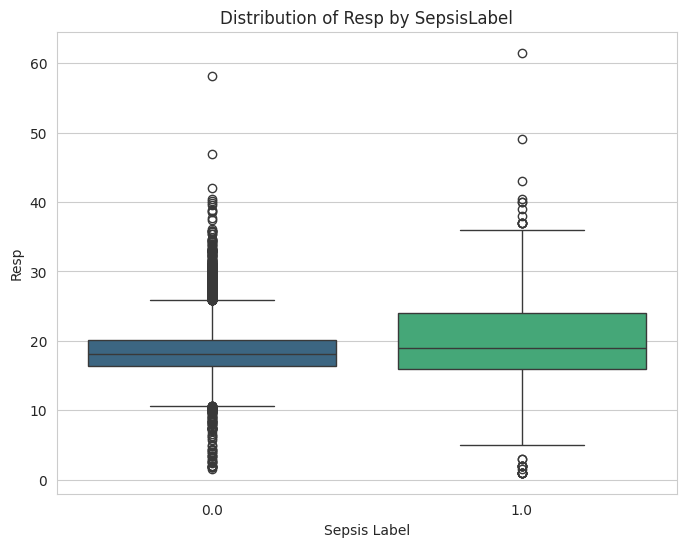

/tmp/ipython-input-3334111865.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='SepsisLabel', y=col, data=aggregated_df, palette='viridis')


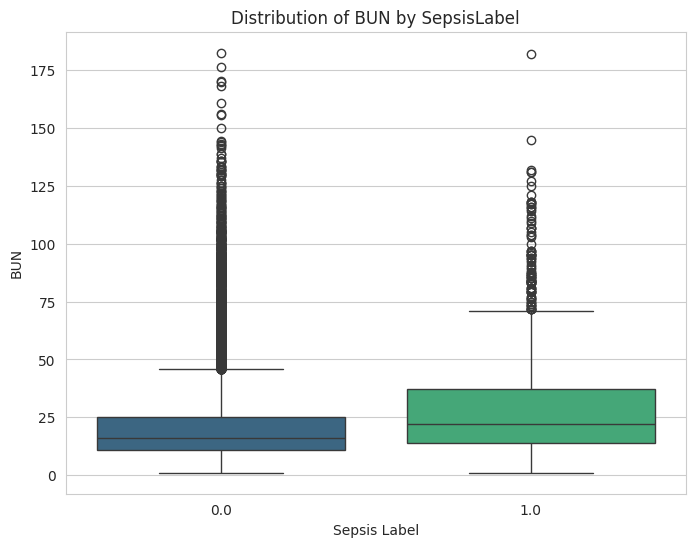

/tmp/ipython-input-3334111865.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='SepsisLabel', y=col, data=aggregated_df, palette='viridis')


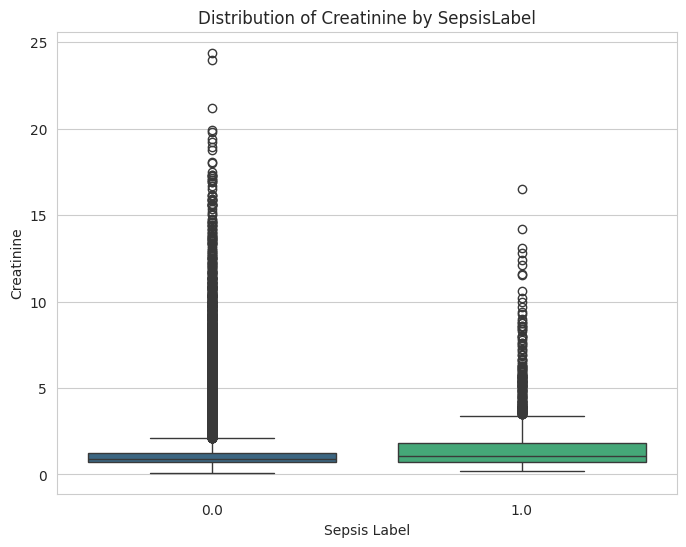

/tmp/ipython-input-3334111865.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='SepsisLabel', y=col, data=aggregated_df, palette='viridis')


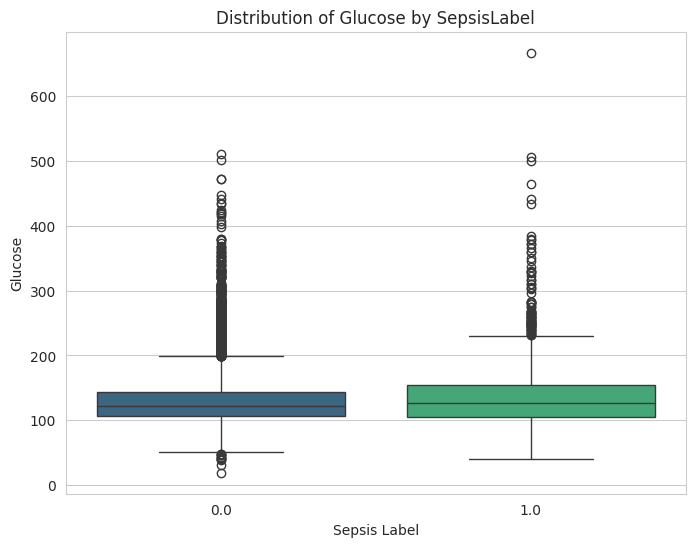

/tmp/ipython-input-3334111865.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='SepsisLabel', y=col, data=aggregated_df, palette='viridis')


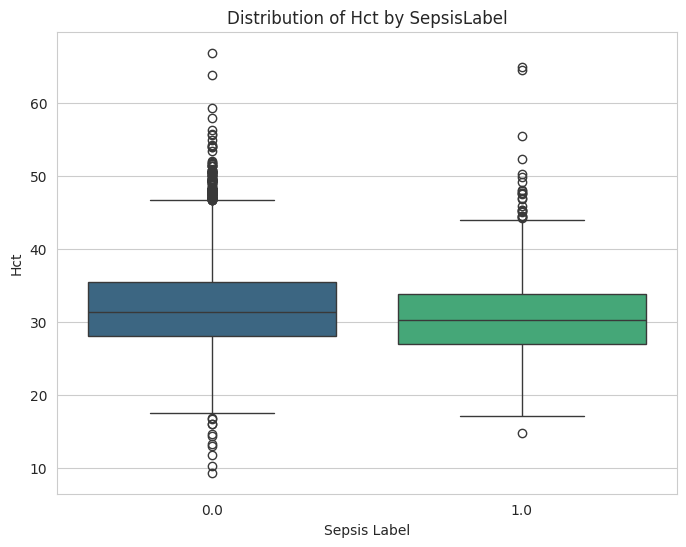

/tmp/ipython-input-3334111865.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='SepsisLabel', y=col, data=aggregated_df, palette='viridis')


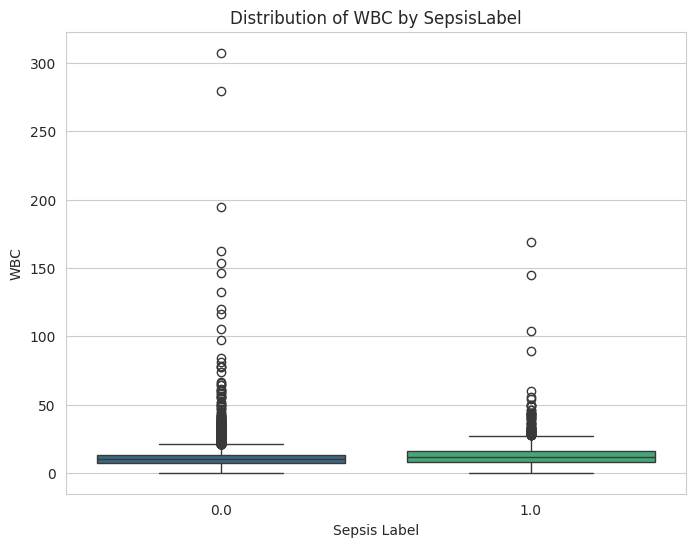

/tmp/ipython-input-3334111865.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='SepsisLabel', y=col, data=aggregated_df, palette='viridis')


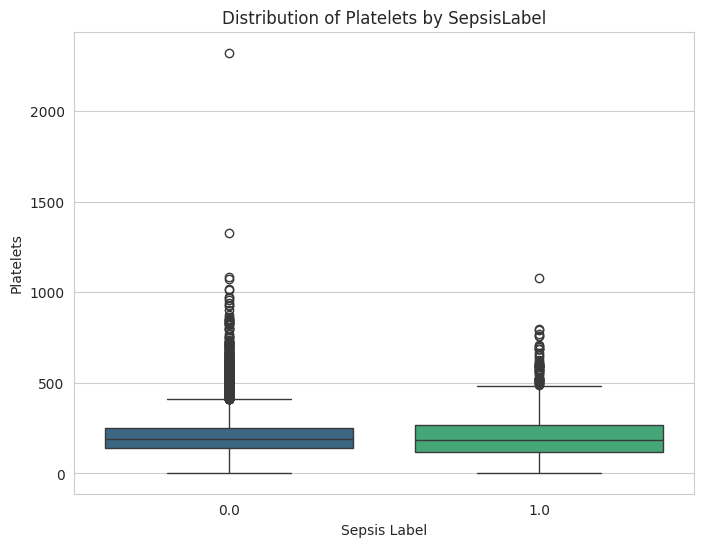

/tmp/ipython-input-3334111865.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='SepsisLabel', y=col, data=aggregated_df, palette='viridis')


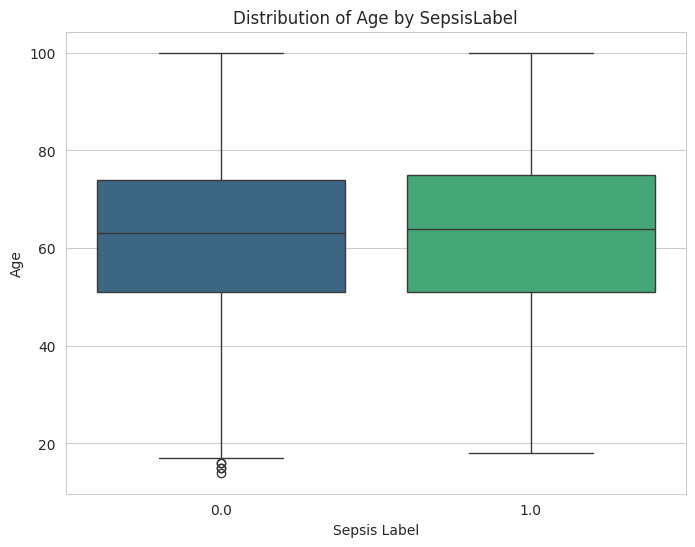

/tmp/ipython-input-3334111865.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='SepsisLabel', y=col, data=aggregated_df, palette='viridis')


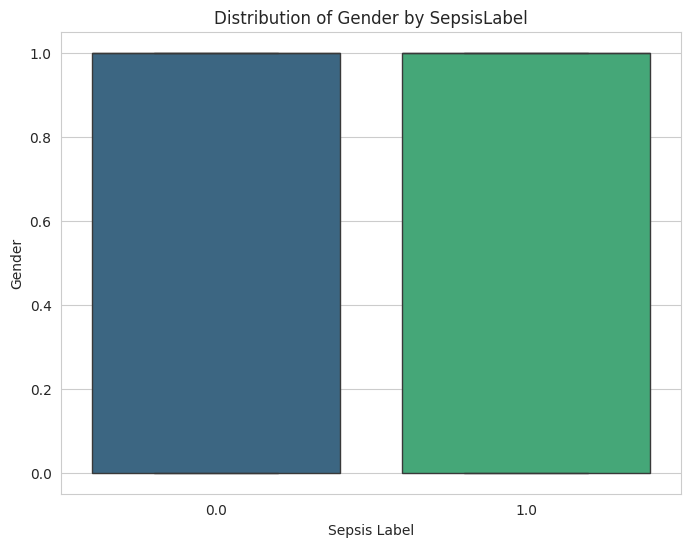

/tmp/ipython-input-3334111865.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='SepsisLabel', y=col, data=aggregated_df, palette='viridis')


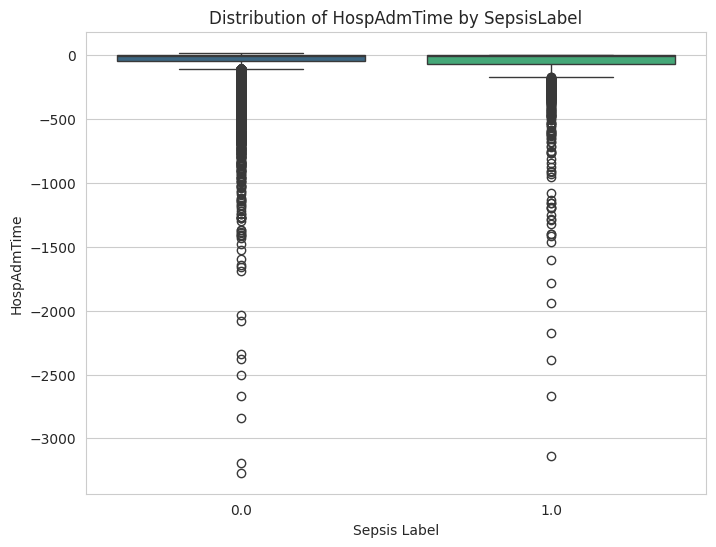

/tmp/ipython-input-3334111865.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='SepsisLabel', y=col, data=aggregated_df, palette='viridis')


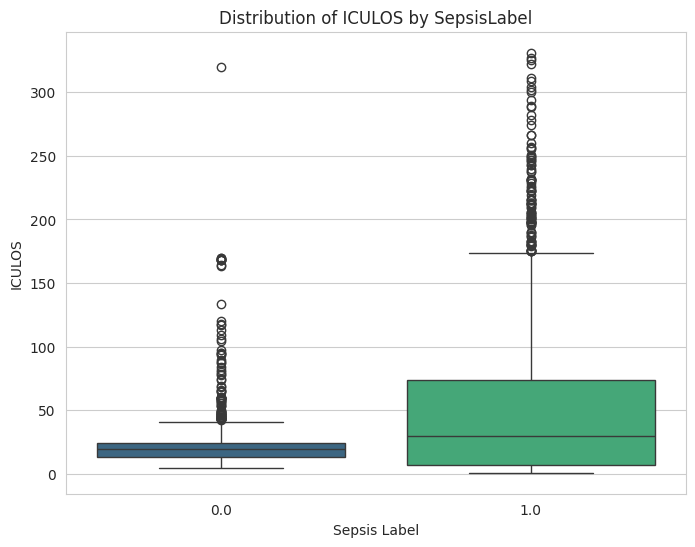

In [179]:
numeric_cols = aggregated_df.select_dtypes(include=np.number).columns.tolist()
# Exclude 'patient' and 'SepsisLabel' from the list of columns to plot
columns_to_plot = [col for col in numeric_cols if col not in ['patient', 'SepsisLabel', 'time']]

# Set a style for the plots
sns.set_style("whitegrid")

# Create boxplots for each numerical column, comparing distributions by SepsisLabel
for col in columns_to_plot:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='SepsisLabel', y=col, data=aggregated_df, palette='viridis')
    plt.title(f'Distribution of {col} by SepsisLabel')
    plt.xlabel('Sepsis Label')
    plt.ylabel(col)
    plt.show()

##Logistic Regression
Next, we will fit a logistic regression model in order to predict 'Sepsis' using all the remaining variables except 'Sepsis'. The `sm.GLM()`  function fits *generalized linear models*, a class of
models that includes logistic regression.  Alternatively,
the function `sm.Logit()` fits a logistic regression
model directly. The syntax of
`sm.GLM()` is similar to that of `sm.OLS()`, except
that we must pass in the argument `family=sm.families.Binomial()`
in order to tell `statsmodels` to run a logistic regression rather than some other
type of generalized linear model.

In [180]:
# by oserving different plots, it can be concluded that only log was somewhat effective and that too for MAP, BUN, Creatinine, Glucose, WBC & Plateletes
# therefore applying log transformations on the above columns

columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
for i in columns_normalized:
  train_df_impute[i] = np.log(train_df_impute[i]+1)

In [181]:
aggregated_df.head()

,patient,HR,O2Sat,Temp,MAP,Resp,BUN,Creatinine,Glucose,Hct,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel
0,6,89.0,100.0,37.39,86.0,22.0,7.0,0.7,75.0,28.6,10.3,193.0,58.18,1.0,-181.00,69.0,1.0
1,33,111.0,96.0,37.00,97.0,18.0,23.0,0.6,117.0,32.8,8.4,129.0,30.04,0.0,-0.02,113.0,1.0
2,37,63.0,90.0,36.39,64.0,17.0,85.0,1.4,78.0,32.6,13.8,103.0,59.73,1.0,-1197.09,183.0,1.0
3,54,88.0,100.0,36.11,76.0,17.0,51.0,5.7,163.0,31.7,18.9,365.0,65.75,1.0,-96.90,123.0,1.0
4,62,116.0,99.0,37.44,73.0,18.0,32.0,1.4,106.0,23.0,17.9,759.0,37.05,0.0,-304.97,104.0,1.0


### Imputating missing value without SMOTE

In [182]:
from sklearn.preprocessing import StandardScaler

# Step 1: Fill NaN values with mean (excluding 'SepsisLabel')
columns_to_fill = aggregated_df.columns.drop('SepsisLabel')

for col in columns_to_fill:
    if col in aggregated_df.columns:
        aggregated_df[col].fillna(aggregated_df[col].mean(), inplace=True)

# Verify no NaN values remain (except possibly in SepsisLabel)
print("NaN counts after filling:")
print(aggregated_df[columns_to_fill].isna().sum())
print()

# Step 2: Create design matrix
allvars = aggregated_df.columns.drop(['SepsisLabel'])
design = MS(allvars)
X = design.fit_transform(aggregated_df)
y = aggregated_df.SepsisLabel == 1

# Step 3: Normalize features (excluding intercept)
# Separate intercept from other features
intercept = X['intercept']
features = X.drop('intercept', axis=1)

# Apply StandardScaler
scaler = StandardScaler()
features_scaled = pd.DataFrame(
    scaler.fit_transform(features),
    columns=features.columns,
    index=features.index
)

# Recombine with intercept
X_normalized = pd.concat([intercept, features_scaled], axis=1)

print("Shape of normalized X:", X_normalized.shape)
print("\nFirst few rows of normalized data:")
print(X_normalized.head())
print("\nFeature statistics after normalization:")
print(features_scaled.describe())

# Step 4: Fit logistic regression
glm = sm.GLM(y, X_normalized, family=sm.families.Binomial())
results = glm.fit()
summarize(results)

/tmp/ipython-input-2277880982.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  aggregated_df[col].fillna(aggregated_df[col].mean(), inplace=True)


NaN counts after filling:
patient        0
HR             0
O2Sat          0
Temp           0
MAP            0
Resp           0
BUN            0
Creatinine     0
Glucose        0
Hct            0
WBC            0
Platelets      0
Age            0
Gender         0
HospAdmTime    0
ICULOS         0
dtype: int64

Shape of normalized X: (22588, 17)

First few rows of normalized data:
   intercept   patient        HR     O2Sat      Temp       MAP      Resp  \
0        1.0 -1.731427  0.345120  1.236630  0.972285  0.239399  0.960157   
1        1.0 -1.728118  1.826906 -0.480400  0.277387  1.078875 -0.150823   
2        1.0 -1.727628 -1.406082 -3.055945 -0.809505 -1.439555 -0.428568   
3        1.0 -1.725545  0.277766  1.236630 -1.308406 -0.523762 -0.428568   
4        1.0 -1.724564  2.163676  0.807372  1.061374 -0.752710 -0.150823   

        BUN  Creatinine   Glucose       Hct       WBC  Platelets       Age  \
0 -0.856189   -0.423719 -1.446992 -0.617513 -0.110688  -0.115080 -0.207406   
1  0

,coef,std err,z,P>|z|
intercept,-2.9315,0.033,-88.549,0.000
patient,0.0125,0.029,0.430,0.667
HR,0.2770,0.031,8.922,0.000
O2Sat,0.0734,0.031,2.390,0.017
Temp,0.2007,0.029,6.846,0.000
MAP,-0.1202,0.031,-3.888,0.000
Resp,0.1722,0.027,6.419,0.000
BUN,0.2188,0.032,6.773,0.000
Creatinine,0.0410,0.034,1.217,0.224
Glucose,0.1176,0.027,4.400,0.000


In [183]:
# Get predicted probabilities from the model
probs = results.predict(X_normalized)

# Create labels: 1 if probability > 0.5, else 0
labels = np.zeros(len(probs), dtype=int)  # Initialize all as 0
labels[probs > 0.5] = 1  # Set to 1 where probability > 0.5

print("Predicted labels:")
print(labels)

# Or more concisely:
labels = (probs > 0.5).astype(int)

# Check distribution of predictions
print("\nPrediction distribution:")
print(pd.Series(labels).value_counts())

Predicted labels:
[0 1 1 ... 0 0 0]

Prediction distribution:
0    22115
1      473
Name: count, dtype: int64


### Imputating missing value & SMOTE

In [184]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Step 1: Fill NaN values with mean (excluding 'SepsisLabel')
columns_to_fill = aggregated_df.columns.drop('SepsisLabel')

for col in columns_to_fill:
    if col in aggregated_df.columns:
        aggregated_df[col].fillna(aggregated_df[col].mean(), inplace=True)

# Verify no NaN values remain
print("NaN counts after filling:")
print(aggregated_df[columns_to_fill].isna().sum())
print()

# Step 2: Create design matrix
allvars = aggregated_df.columns.drop(['SepsisLabel'])
design = MS(allvars)
X = design.fit_transform(aggregated_df)
y = aggregated_df.SepsisLabel == 1

# Step 3: Normalize features (excluding intercept)
intercept = X['intercept']
features = X.drop('intercept', axis=1)

scaler = StandardScaler()
features_scaled = pd.DataFrame(
    scaler.fit_transform(features),
    columns=features.columns,
    index=features.index
)

X_normalized = pd.concat([intercept, features_scaled], axis=1)

print("Class distribution BEFORE SMOTE:")
print(y.value_counts())
print(f"Positive class ratio: {y.sum() / len(y):.2%}\n")

# Step 4: Apply SMOTE to training data
# Remove intercept temporarily for SMOTE
X_for_smote = X_normalized.drop('intercept', axis=1)

smote = SMOTE(random_state=42, sampling_strategy='auto')  # Adjust sampling_strategy as needed
X_resampled, y_resampled = smote.fit_resample(X_for_smote, y)

# Add intercept back
X_resampled = pd.DataFrame(X_resampled, columns=X_for_smote.columns)
X_resampled.insert(0, 'intercept', 1.0)

print("Class distribution AFTER SMOTE:")
print(pd.Series(y_resampled).value_counts())
print(f"Positive class ratio: {y_resampled.sum() / len(y_resampled):.2%}\n")

# Step 5: Fit logistic regression
glm = sm.GLM(y_resampled, X_resampled, family=sm.families.Binomial())
results = glm.fit()
summarize(results)

NaN counts after filling:
patient        0
HR             0
O2Sat          0
Temp           0
MAP            0
Resp           0
BUN            0
Creatinine     0
Glucose        0
Hct            0
WBC            0
Platelets      0
Age            0
Gender         0
HospAdmTime    0
ICULOS         0
dtype: int64

Class distribution BEFORE SMOTE:
SepsisLabel
False    20946
True      1642
Name: count, dtype: int64
Positive class ratio: 7.27%

Class distribution AFTER SMOTE:
SepsisLabel
True     20946
False    20946
Name: count, dtype: int64
Positive class ratio: 50.00%



/tmp/ipython-input-143907526.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  aggregated_df[col].fillna(aggregated_df[col].mean(), inplace=True)


,coef,std err,z,P>|z|
intercept,-0.3755,0.012,-32.588,0.000
patient,0.0483,0.012,4.176,0.000
HR,0.2588,0.012,22.103,0.000
O2Sat,0.1105,0.010,10.593,0.000
Temp,0.1513,0.010,15.367,0.000
MAP,-0.1190,0.011,-10.922,0.000
Resp,0.1591,0.010,16.393,0.000
BUN,0.2599,0.015,16.826,0.000
Creatinine,0.0061,0.015,0.399,0.690
Glucose,0.1002,0.011,9.510,0.000


In [185]:
# Get predicted probabilities from the model
probs = results.predict(X_resampled)

# Create labels: 1 if probability > 0.5, else 0
labels = np.zeros(len(probs), dtype=int)  # Initialize all as 0
labels[probs > 0.5] = 1  # Set to 1 where probability > 0.5

print("Predicted labels:")
print(labels)

# Or more concisely:
labels = (probs > 0.5).astype(int)

# Check distribution of predictions
print("\nPrediction distribution:")
print(pd.Series(labels).value_counts())

Predicted labels:
[1 1 1 ... 0 1 1]

Prediction distribution:
0    24585
1    17307
Name: count, dtype: int64


### Confusion Table
Evaluate on original data AFTER imputation and normalization

Logistic Regression Classification Report (on Resampled Training Data):
               precision    recall  f1-score   support

No Sepsis (0)       0.68      0.79      0.73     20946
   Sepsis (1)       0.75      0.62      0.68     20946

     accuracy                           0.71     41892
    macro avg       0.71      0.71      0.70     41892
 weighted avg       0.71      0.71      0.70     41892



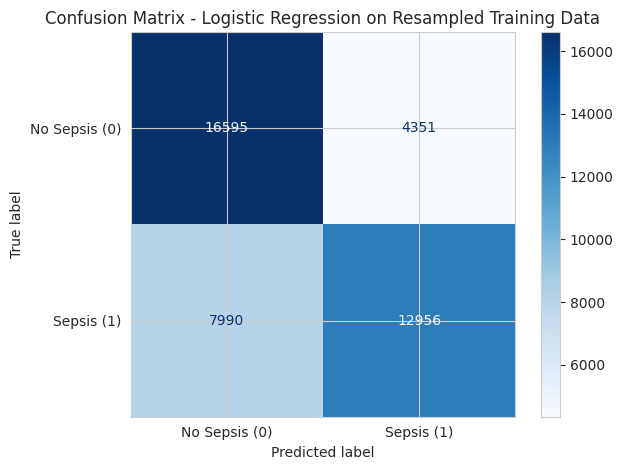

In [190]:
## Evaluation on the training data
# Logistic Regression using sklearn
logreg = LogisticRegression(max_iter=1000)

# Fit on the resampled training data (after SMOTE)
# X_resampled contains features, y_resampled contains labels
logreg.fit(X_resampled, y_resampled)

# Make predictions on the same resampled training data
y_pred_logreg = logreg.predict(X_resampled)

# Print Classification Report
print("Logistic Regression Classification Report (on Resampled Training Data):")
print(classification_report(y_resampled, y_pred_logreg,
                           target_names=['No Sepsis (0)', 'Sepsis (1)']))

# Create and display confusion matrix
cm = confusion_matrix(y_resampled, y_pred_logreg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['No Sepsis (0)', 'Sepsis (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Logistic Regression on Resampled Training Data')
plt.tight_layout()
plt.show()